### Plots for RWKV preprint

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from pathlib import Path
from typing import Union

In [21]:
BASE_PATH = Path("data/")

In [206]:
def groupby_first_n(df: pd.DataFrame, args: Union[str, list[str]] , n: int = None): #  -> pd.GroupBy: 
    """ Keeps up to the first N in a groupby. If n=None, keeps largest possible. """
    new_df = []
    for els, dfs in df.groupby(args): 
        new_df.append(dfs[:n].sort_values("token_id"))
        print(els, dfs.shape)
    return pd.concat(new_df).groupby(args)

### Cumulative time plot

In [253]:
df = pd.read_csv(BASE_PATH / "inference_results_hf_cuda.csv")
df_rwkv = pd.read_csv(BASE_PATH / "inference_results_rwkv_cuda.csv")

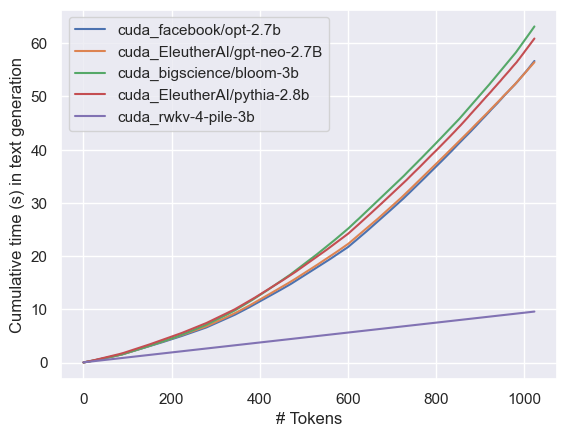

In [260]:
for model_name in ["facebook/opt-2.7b", "EleutherAI/gpt-neo-2.7B", "bigscience/bloom-3b", "EleutherAI/pythia-2.8b",]: 
    plt.plot(np.cumsum(df[df["model_name"] == model_name].cuda_time.values*10**(-6)), label="cuda_"+model_name)
    
plt.plot(np.cumsum(df_rwkv[df_rwkv["model_name"] == "BlinkDL/rwkv-4-pile-3b"].cuda_time.values*10**(-6)), label="cuda_"+"rwkv-4-pile-3b")
plt.legend()
plt.xlabel("# Tokens")
plt.ylabel(f"Cumulative time (s) in text generation")
plt.show()

### Time Plot

In [207]:
df = pd.read_csv(BASE_PATH / "inference_results_hf_cuda.csv")
df_cpu = pd.read_csv(BASE_PATH / "inference_results_hf.csv")
df_cpu = df_cpu[df_cpu.strategy.str.contains("cpu")]
df_rwkv = pd.read_csv(BASE_PATH / "inference_results_rwkv_cuda.csv")
df_rwkv_cpu = pd.read_csv(BASE_PATH / "inference_results_rwkv.csv")
df_rwkv_cpu = df_rwkv_cpu[df_rwkv_cpu.strategy.str.contains("cpu")]

In [218]:
df["time"] = df["cuda_time"]
df_cpu["time"] = df_cpu["cpu_time"]
df_rwkv["time"] = df_rwkv["cuda_time"]
df_rwkv_cpu["time"] = df_rwkv_cpu["cpu_time"]

In [219]:
df = pd.concat([df, df_cpu])
df_rwkv = pd.concat([df_rwkv, df_rwkv_cpu])

In [220]:
max_toks = 512
df_ = groupby_first_n(df, ["model_name", "strategy"], n=max_toks)[["time"]].sum()
df_rwkv_ = groupby_first_n(df_rwkv, ["model_name", "strategy"], n=max_toks)[["time"]].sum()
main_df = pd.concat([df_, df_rwkv_]).reset_index()

('EleutherAI/gpt-neo-1.3B', 'cuda') (1024, 16)
('EleutherAI/gpt-neo-125m', 'cpu') (2048, 16)
('EleutherAI/gpt-neo-125m', 'cuda') (1024, 16)
('EleutherAI/gpt-neo-2.7B', 'cuda') (1024, 16)
('EleutherAI/pythia-1.4b', 'cuda') (1024, 16)
('EleutherAI/pythia-12b', 'cuda') (868, 16)
('EleutherAI/pythia-160m', 'cpu') (2048, 16)
('EleutherAI/pythia-160m', 'cuda') (1024, 16)
('EleutherAI/pythia-2.8b', 'cuda') (1024, 16)
('EleutherAI/pythia-410m', 'cuda') (1024, 16)
('EleutherAI/pythia-6.9b', 'cuda') (1024, 16)
('bigscience/bloom-1b7', 'cuda') (1024, 16)
('bigscience/bloom-3b', 'cpu') (1198, 16)
('bigscience/bloom-3b', 'cuda') (1024, 16)
('bigscience/bloom-560m', 'cpu') (2048, 16)
('bigscience/bloom-560m', 'cuda') (1024, 16)
('facebook/opt-1.3b', 'cuda') (1024, 16)
('facebook/opt-125m', 'cpu') (2048, 16)
('facebook/opt-125m', 'cuda') (1024, 16)
('facebook/opt-13b', 'cuda') (701, 16)
('facebook/opt-2.7b', 'cuda') (1024, 16)
('facebook/opt-350m', 'cpu') (1284, 16)
('facebook/opt-350m', 'cuda') (102

In [221]:
scale = {"B": 10**9, "m": 10**6, "b": 10**9}
main_df["model_name"] = main_df["model_name"].str.replace("b5", "b").str.replace("b7", "b")
main_df["class"] = main_df["model_name"].apply(lambda x: '-'.join(x.split("/")[1].split("-")[:-1]))
main_df["size"] = main_df["model_name"].apply(lambda x: float(x.split("-")[-1][:-1]) * scale[x.split("-")[-1][-1]])
main_df["strategy"] = main_df["strategy"].apply(lambda x: "cuda" if "cuda" in x else "cpu")
main_df = main_df.sort_values(["size", "strategy"])

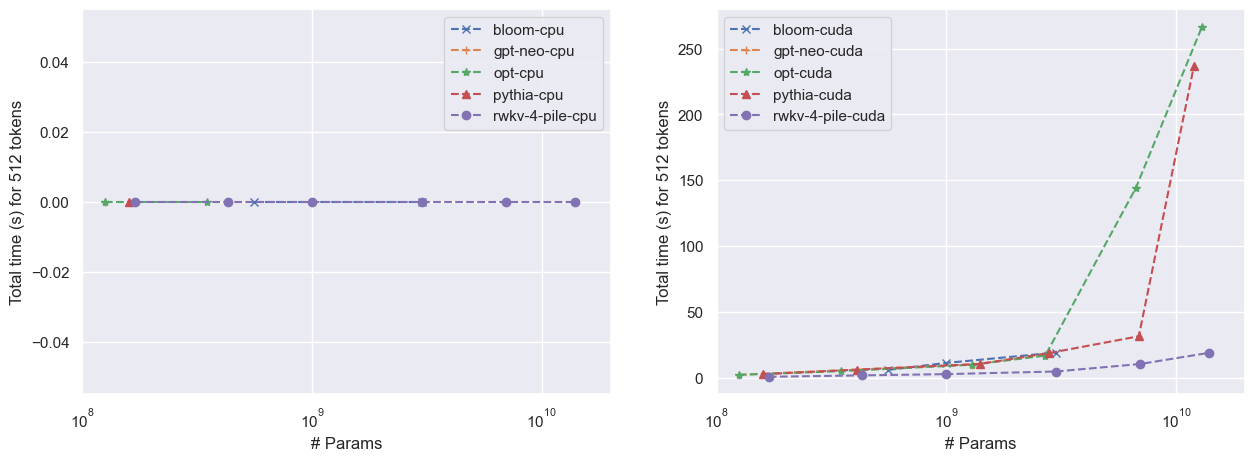

In [223]:
colors = ["r", "b", "g", "y", "k"]
icons = "x+*^o"
alpha = {"cpu": 0.5, "cuda": 1.0}

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i, (class_, model_df) in enumerate(main_df.groupby("class")): 
    for s, strategy in enumerate(["cpu", "cuda"]):
        mask = model_df["strategy"] == strategy
        # axs[s].plot(model_df[mask]["size"], model_df[mask]["cpu_time"]*10**(-6), f'{colors[i]}{icons[i]}--', label=f"{class_}-{strategy}")
        axs[s].plot(model_df[mask]["size"], model_df[mask]["time"]*10**(-6), f'{icons[i]}--', label=f"{class_}-{strategy}")

for s in [0, 1]: 
    axs[s].legend()
    axs[s].set_xscale("log")
    # axs[s].set_yscale("log")
    axs[s].set_xlabel("# Params")
    axs[s].set_ylabel(f"Total time (s) for {max_toks} tokens")
    axs[s].set_xlim(10**8, 2.*10**10)
plt.savefig("fig.svg")

### VRAM plot

In [227]:
df = pd.read_csv(BASE_PATH / "inference_results_hf_cuda.csv")
df_cpu = pd.read_csv(BASE_PATH / "inference_results_hf.csv")
df_cpu = df_cpu[df_cpu.strategy.str.contains("cpu")]
df_rwkv = pd.read_csv(BASE_PATH / "inference_results_rwkv_cuda.csv")
df_rwkv_cpu = pd.read_csv(BASE_PATH / "inference_results_rwkv.csv")
df_rwkv_cpu = df_rwkv_cpu[df_rwkv_cpu.strategy.str.contains("cpu")]

In [237]:
df["memory"] = df["self_cuda_memory_usage"].abs()
df_cpu["memory"] = df_cpu["self_cpu_memory_usage"].abs()
df_rwkv["memory"] = df_rwkv["self_cuda_memory_usage"].abs()
df_rwkv_cpu["memory"] = df_rwkv_cpu["self_cpu_memory_usage"].abs()

In [238]:
df = pd.concat([df, df_cpu])
df_rwkv = pd.concat([df_rwkv, df_rwkv_cpu])

In [239]:
# df["memory"] = np.maximum(df["cpu_memory_usage"].values, df["cuda_memory_usage"].values)
# df_rwkv["memory"] = np.maximum(df_rwkv["cpu_memory_usage"].values, df_rwkv["cuda_memory_usage"].values)

max_toks = 512
df_ = groupby_first_n(df, ["model_name", "strategy"], n=max_toks)[["memory"]].last()
df_rwkv_ = groupby_first_n(df_rwkv, ["model_name", "strategy"], n=max_toks)[["memory"]].sum()
main_df = pd.concat([df_, df_rwkv_]).reset_index()

('EleutherAI/gpt-neo-1.3B', 'cuda') (1024, 16)
('EleutherAI/gpt-neo-125m', 'cpu') (2048, 16)
('EleutherAI/gpt-neo-125m', 'cuda') (1024, 16)
('EleutherAI/gpt-neo-2.7B', 'cuda') (1024, 16)
('EleutherAI/pythia-1.4b', 'cuda') (1024, 16)
('EleutherAI/pythia-12b', 'cuda') (868, 16)
('EleutherAI/pythia-160m', 'cpu') (2048, 16)
('EleutherAI/pythia-160m', 'cuda') (1024, 16)
('EleutherAI/pythia-2.8b', 'cuda') (1024, 16)
('EleutherAI/pythia-410m', 'cuda') (1024, 16)
('EleutherAI/pythia-6.9b', 'cuda') (1024, 16)
('bigscience/bloom-1b7', 'cuda') (1024, 16)
('bigscience/bloom-3b', 'cpu') (1198, 16)
('bigscience/bloom-3b', 'cuda') (1024, 16)
('bigscience/bloom-560m', 'cpu') (2048, 16)
('bigscience/bloom-560m', 'cuda') (1024, 16)
('facebook/opt-1.3b', 'cuda') (1024, 16)
('facebook/opt-125m', 'cpu') (2048, 16)
('facebook/opt-125m', 'cuda') (1024, 16)
('facebook/opt-13b', 'cuda') (701, 16)
('facebook/opt-2.7b', 'cuda') (1024, 16)
('facebook/opt-350m', 'cpu') (1284, 16)
('facebook/opt-350m', 'cuda') (102

In [240]:
scale = {"B": 10**9, "m": 10**6, "b": 10**9}
main_df["model_name"] = main_df["model_name"].str.replace("b5", "b").str.replace("b7", "b")
main_df["class"] = main_df["model_name"].apply(lambda x: '-'.join(x.split("/")[1].split("-")[:-1]))
main_df["size"] = main_df["model_name"].apply(lambda x: float(x.split("-")[-1][:-1]) * scale[x.split("-")[-1][-1]])
main_df["strategy"] = main_df["strategy"].apply(lambda x: "cuda" if "cuda" in x else "cpu")
main_df = main_df.sort_values(["size", "strategy"])

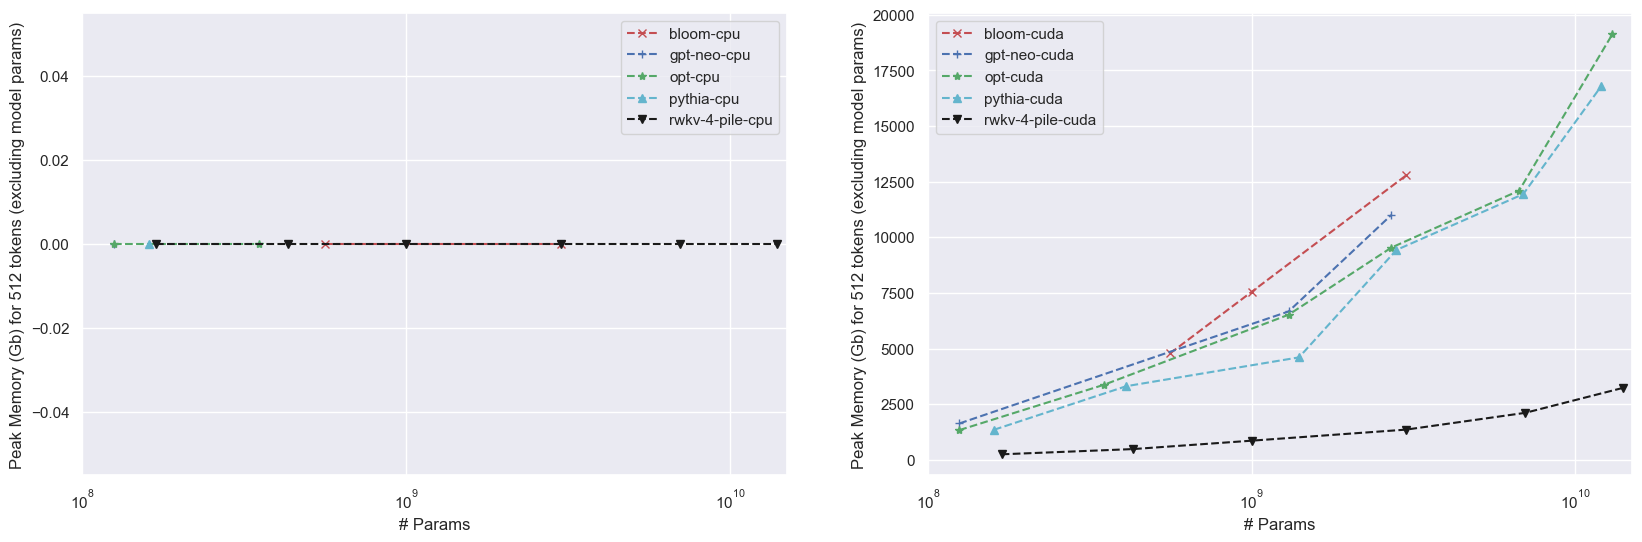

In [242]:
colors = "rbgck"
icons = "x+*^v"
alpha = {"cpu": 0.5, "cuda": 1.0}

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

for i, (class_, model_df) in enumerate(main_df.groupby("class")): 
    for s, strategy in enumerate(["cpu", "cuda"]):
        mask = model_df["strategy"] == strategy
        axs[s].plot(model_df[mask]["size"], model_df[mask]["memory"]*10**(-6), f'{colors[i]}{icons[i]}--', label=f"{class_}-{strategy}") # , alpha=alpha[strategy])

for s in [0, 1]: 
    axs[s].legend()
    axs[s].set_xscale("log")
    # axs[s].set_yscale("log")
    axs[s].set_xlabel("# Params")
    axs[s].set_ylabel(f"Peak Memory (Gb) for {max_toks} tokens (excluding model params)")
    axs[s].set_xlim(10**8, 1.5*10**10)